In [357]:
import xarray as xr
import numpy as np
import tools
import matplotlib.pyplot as plt
import pandas as pd
from glob import glob

# Create Observations for OSSE

Using the WMOP forecast as a nature run for our OSSE experiment we are going to prepare the sinthetic observations for Assimilation

- The period of the experiment is the same as the OSE HFradar assimilation experiments previosuly realized (20 September to 20 October 2014)

- WMOP forecast used as Nature run. For the period selected the model, by coincidence, was not restarted from and thus we have a continuos free run, as we liked to.  In the future using WMOP hindcast MERCATOR as NR may be considered

- Observations from real sources will be simulated by interpolating the NR field to the observqation points. Histogram of innovations (difference between virtual observation and model) should be regarded and compared against the innovations of the real observations 

- Virtual HF radar antennas in Denia will be simulated by supossing a virtual rdar footprint and considering the observations of the surface velocitu fields within it, considering also possible gaps in the coverage area
                                                                                                        

#### Define Paths to Observations and NR

In [358]:
obs_path = '/DATA/jhernandez/WMOP_ASSIM/Observations/HFR_all_nudging_Oct2014/'
nr_path = '/home/modelling/data/WMOP/WMOP_FORECAST/Outputs/FORECAST_CMEMS_RESTARTS/forecast_scratch/'

#### Load Observations

In [359]:
obsfile = glob(obs_path + '*obs')
obsfile.sort()

df = tools.read_obsfile(obsfile[0])

#### Get Altimetry Observations

In [360]:
strdate = '20140920'

# WMOP MDT
file_mdt = '/data/modelling/WMOP_ASSIM/Inputs/roms_WMOP_HINDCAST_synthetic_201505_201704_mean.nc'
ds_mdt = xr.open_dataset(file_mdt)

file_wmop = '{0}/roms_WMOP_FORECAST_{1}_his.nc'.format(nr_path, strdate)
ds_wmop = xr.open_dataset(file_wmop)

# Subset Altimetry Observations
df_sla = df[df['var']=='h']


In [361]:
import scipy.interpolate as interp
from datetime import datetime 
from datetime import timedelta

In [362]:
t0 = datetime.now()

# Subset Observations
#df_sla2 = df_sla.iloc[0:300]

# Create empty array
sla_interp = np.array([])

for i in range(len(df_sla)):

    obs = df_sla.iloc[i]
    date_obs = datetime(obs['year'], obs['month'], obs['day'], obs['hour'], obs['minute'])
    strdate_obs = date.strftime('%Y%m%d')
    
    # Load NR file to extract observations from
    file_wmop = '{0}/roms_WMOP_FORECAST_{1}_his.nc'.format(nr_path, strdate_obs)
    ds_wmop = xr.open_dataset(file_wmop)
    
    # Get time slot to extract obs from
    dt = np.diff(ds_wmop.ocean_time.values) / np.timedelta64(1, 'h')
    dt = int(np.unique(dt))
    idt = obs.hour // dt
    
    # Get SSH
    sla0 = ds_wmop.zeta[idt,:,:].values - ds_mdt.zeta[0,:,:].values
    sla0[np.isnan(sla0)] = 10000
    fz = interp.interp2d(ds_wmop.lon_rho[1,:].values, ds_wmop.lat_rho[:,1].values, sla0, kind='linear')
    
    sla1 = ds_wmop.zeta[idt+1,:,:].values - ds_mdt.zeta[0,:,:].values
    sla1[np.isnan(sla1)] = 10000
    fz1 = interp.interp2d(ds_wmop.lon_rho[1,:].values, ds_wmop.lat_rho[:,1].values, sla1, kind='linear')

    s0 = fz(obs.lon, obs.lat)
    s1 = fz(obs.lon, obs.lat)
    
    # ponderate sla obs with weights
    w1 = ( (obs.hour + obs.minute/60) / dt) - obs.hour//dt
    sla_interp = np.concatenate((sla_interp, w1*s1 + (1-w1)*s0))


df_sla['sla_interp'] =  sla_interp
df_sla[['val', 'sla_interp']]

tf = datetime.now()

print(' Tiempo total = {0}'.format((tf-t0).total_seconds()))

 Tiempo total = 83.768054


/DATA/jhernandez/Softs/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


### Comparison of real and sinthetic SLA observations

#### Description

In [366]:
print(df_sla[['val','sla_interp']].describe())
#df_sla[['val','sla_interp']].describe().to_latex()

              val  sla_interp
count  850.000000  850.000000
mean     0.151833    0.188028
std      0.052638    0.057292
min     -0.006000    0.037636
25%      0.113250    0.147624
50%      0.146000    0.183987
75%      0.185000    0.230088
max      0.345000    0.362678


#### Plot

In [367]:
import matplotlib
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 12}

matplotlib.rc('font', **font)

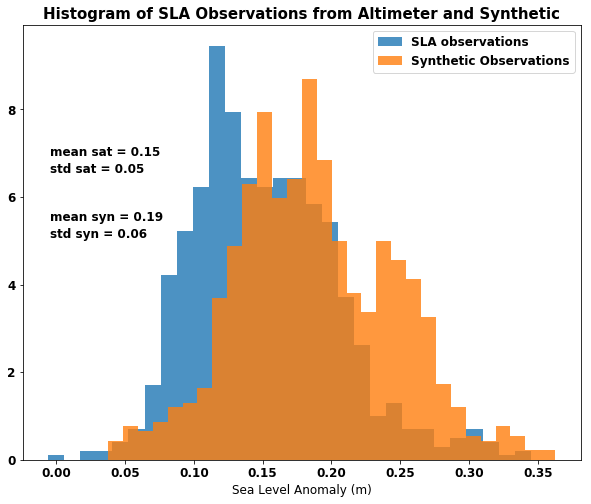

In [376]:
fig_sla_hist = plt.figure(figsize=(10,8))
ax = plt.subplot(111)

plt.hist(df_sla['val'], 30, density=True, alpha=0.8)
plt.hist(df_sla['sla_interp'], 30, density=True, alpha=0.8)

plt.legend(['SLA observations', 'Synthetic Observations'])
plt.title('Histogram of SLA Observations from Altimeter and Synthetic', fontsize=15, fontweight='bold')
plt.xlabel('Sea Level Anomaly (m)')

plt.text(0.05, 0.7, 'mean sat = {0:0.2f}'.format(np.mean(df_sla['val'])), transform=ax.transAxes)
plt.text(0.05, 0.66, 'std sat = {0:0.2f}'.format(np.std(df_sla['val'])), transform=ax.transAxes)

plt.text(0.05, 0.55, 'mean syn = {0:0.2f}'.format(np.mean(df_sla['sla_interp'])), transform=ax.transAxes)
plt.text(0.05, 0.51, 'std syn = {0:0.2f}'.format(np.std(df_sla['sla_interp'])), transform=ax.transAxes)


plt.show()

In [377]:
fig_sla_hist.savefig('/home/jhernandez/Escritorio/histogram_sla_observations_OSSE.png', dpi=250)

## Get SST Observations

In [235]:
df_sst = df[df['source']=='GHRSST_JPL'].reset_index(drop=True)

In [236]:
date = df_sst[['year', 'month', 'day', 'hour', 'minute']].drop_duplicates()
date = datetime(date['year'], date['month'], date['day'], date['hour'], date['minute'])
strdate = date.strftime('%Y%m%d')

In [325]:
t0 = datetime.now()

# Load NR file to extract observations from
file_wmop = '{0}/roms_WMOP_FORECAST_{1}_his.nc'.format(nr_path, strdate)
ds_wmop = xr.open_dataset(file_wmop)

# Get time slot to extract obs from
dt = np.diff(ds_wmop.ocean_time.values) / np.timedelta64(1, 'h')
dt = int(np.unique(dt))
hour = 9  # observation time desired
idt = hour // dt 

# Get SSH. Interpolate for two time steps according to weights 
sst0 = ds_wmop.temp[idt,-1,:,:].values
sst1 = ds_wmop.temp[idt+1,-1,:,:].values

# ponderate SST obs with weights
w1 = ( hour / dt) - idt
sst = w1*sst1 + (1-w1)*sst0

sst[np.isnan(sst)] = 10000
fz = interp.interp2d(ds_wmop.lon_rho[1,:].values, ds_wmop.lat_rho[:,1].values, sst, kind='linear')

sst_interp = [fz(df_sst.iloc[i].lon, df_sst.iloc[i].lat) for i in range(len(df_sst))]
sst_interp = np.array(sst_interp)


sst_interp[sst_interp>35] = np.nan


df_sst['sst_interp'] =  sst_interp
df_sst[['val', 'sst_interp']]

tf = datetime.now()

print(' Tiempo total = {0}'.format((tf-t0).total_seconds()))

 Tiempo total = 1.839119


### Plot SST Observations

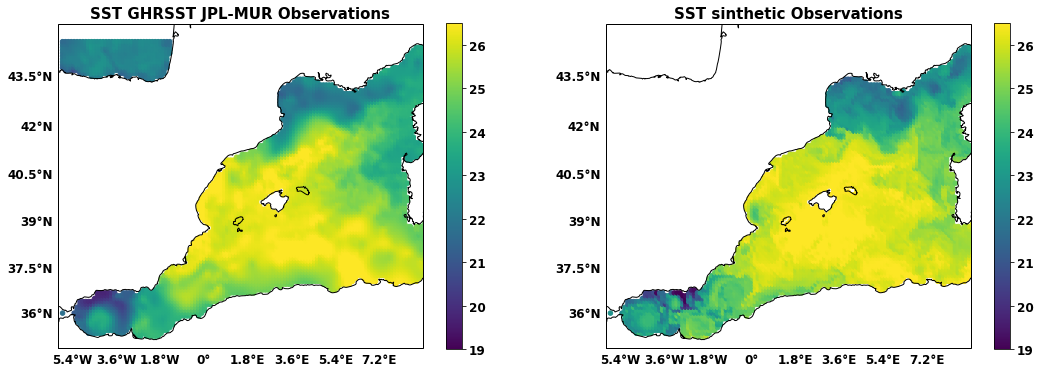

In [244]:
fig_sst = plt.figure(figsize=(18,6))

ax, gl = tools.make_map(continents=False, subplot_dim=121) 
plt.scatter(df_sst.lon, df_sst.lat, 20, df_sst.val, vmin=19, vmax=26.5, transform=gl.crs)
plt.colorbar()
plt.title('SST GHRSST JPL-MUR Observations', fontsize=15, fontweight='bold')

ax, gl = tools.make_map(continents=False, subplot_dim=122) 
plt.scatter(df_sst.lon, df_sst.lat, 20, df_sst.sst_interp, vmin=19, vmax=26.5, transform=gl.crs)
plt.colorbar()
plt.title('SST sinthetic Observations', fontsize=15, fontweight='bold')

plt.show()

### Plot Histogram of Observations

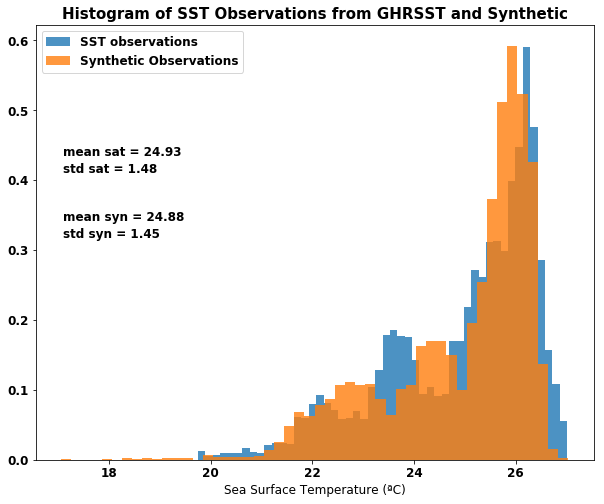

In [381]:
fig_sst_hist = plt.figure(figsize=(10,8))

ax = plt.subplot(111)

plt.hist(df_sst['val'], 50, density=True, alpha=0.8)
plt.hist(df_sst['sst_interp'], 50, density=True, alpha=0.8)

plt.legend(['SST observations', 'Synthetic Observations'])
plt.title('Histogram of SST Observations from GHRSST and Synthetic', fontsize=15, fontweight='bold')
plt.xlabel('Sea Surface Temperature (ªC)')

plt.text(0.05, 0.7, 'mean sat = {0:0.2f}'.format(np.mean(df_sst['val'])), transform=ax.transAxes)
plt.text(0.05, 0.66, 'std sat = {0:0.2f}'.format(np.std(df_sst['val'])), transform=ax.transAxes)

plt.text(0.05, 0.55, 'mean syn = {0:0.2f}'.format(np.mean(df_sst['sst_interp'])), transform=ax.transAxes)
plt.text(0.05, 0.51, 'std syn = {0:0.2f}'.format(np.std(df_sst['sst_interp'])), transform=ax.transAxes)

plt.show()

In [382]:
fig_sst_hist.savefig('/home/jhernandez/Escritorio/histogram_sst_observations_OSSE.png', dpi=250)

#### Describe statistics

In [327]:
print(df_sst[['val','sst_interp']].describe())

               val   sst_interp
count  5327.000000  5327.000000
mean     24.933237    24.883442
std       1.476467     1.449658
min      19.749088    17.051211
25%      23.869133    24.068503
50%      25.410050    25.474630
75%      26.123787    25.983318
max      27.008438    27.030765


In [270]:
print('Lenght of ocean time = {0}.  time step of outputs = {1}h'.format(ds_wmop.ocean_time.shape[0], dt))


Lenght of ocean time = 7.  time step of outputs = 4h


## Get HFR observations

In [392]:
df_uhfr = df[(df['source']=='HF_Radar') & (df['var']=='u')].reset_index(drop=True)
df_vhfr = df[(df['source']=='HF_Radar') & (df['var']=='v')].reset_index(drop=True)

In [393]:

# Interp U
u = ds_wmop.u[:,-1,:,:].mean(axis=0).values
u[np.isnan(u)] = 100000

fu = interp.interp2d(ds_wmop.lon_u[1,:].values, ds_wmop.lat_u[:,1].values, u, kind='linear')
u_interp = [fu(df_uhfr.iloc[i].lon, df_uhfr.iloc[i].lat) for i in range(len(df_uhfr))]
u_interp = np.array(u_interp)
u_interp[u_interp>1000] = np.nan
df_uhfr['u_interp'] = u_interp


# Interp V
v = ds_wmop.v[:,-1,:,:].mean(axis=0).values
v[np.isnan(v)] = 100000

fv = interp.interp2d(ds_wmop.lon_v[1,:].values, ds_wmop.lat_v[:,1].values, v, kind='linear')
v_interp = [fv(df_vhfr.iloc[i].lon, df_vhfr.iloc[i].lat) for i in range(len(df_vhfr))]
v_interp = np.array(v_interp)
v_interp[v_interp>1000] = np.nan
df_vhfr['v_interp'] = v_interp

/DATA/jhernandez/Softs/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [394]:
print(df_uhfr[['val','u_interp']].describe())
print('\n V statistics')
print(df_vhfr[['val','v_interp']].describe())

              val    u_interp
count  318.000000  317.000000
mean     0.014853    0.033213
std      0.039485    0.047415
min     -0.106941   -0.048382
25%     -0.008696   -0.009415
50%      0.023854    0.034578
75%      0.041779    0.065316
max      0.094194    0.155463

 V statistics
              val    v_interp
count  318.000000  318.000000
mean    -0.030916    0.039153
std      0.058470    0.081414
min     -0.258120   -0.141707
25%     -0.054840   -0.021357
50%     -0.018604    0.038471
75%      0.011924    0.108856
max      0.055421    0.199166


### Plot U - velocity

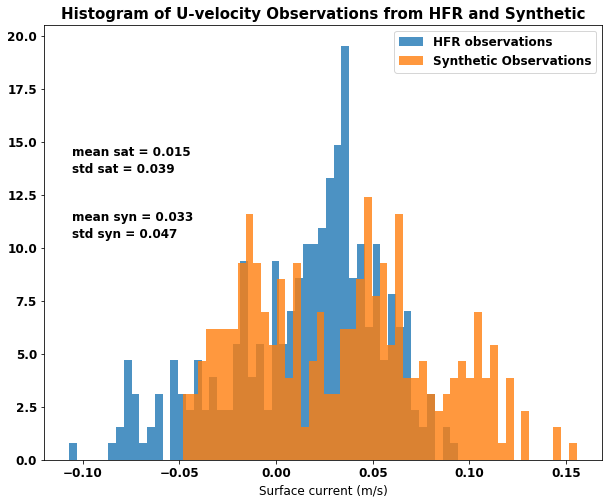

In [395]:
fig_uhfr_hist = plt.figure(figsize=(10,8))
ax = plt.subplot(111)

plt.hist(df_uhfr['val'], 50, density=True, alpha=0.8)
plt.hist(df_uhfr['u_interp'], 50, density=True, alpha=0.8)

plt.legend(['HFR observations', 'Synthetic Observations'])
plt.title('Histogram of U-velocity Observations from HFR and Synthetic', fontsize=15, fontweight='bold')
plt.xlabel('Surface current (m/s)')

plt.text(0.05, 0.7, 'mean sat = {0:0.3f}'.format(np.mean(df_uhfr['val'])), transform=ax.transAxes)
plt.text(0.05, 0.66, 'std sat = {0:0.3f}'.format(np.std(df_uhfr['val'])), transform=ax.transAxes)

plt.text(0.05, 0.55, 'mean syn = {0:0.3f}'.format(np.mean(df_uhfr['u_interp'])), transform=ax.transAxes)
plt.text(0.05, 0.51, 'std syn = {0:0.3f}'.format(np.std(df_uhfr['u_interp'])), transform=ax.transAxes)

plt.show()

In [396]:
fig_uhfr_hist.savefig('/home/jhernandez/Escritorio/histogram_uhfr_observations_OSSE.png', dpi=250)

### Plot  V - velocity

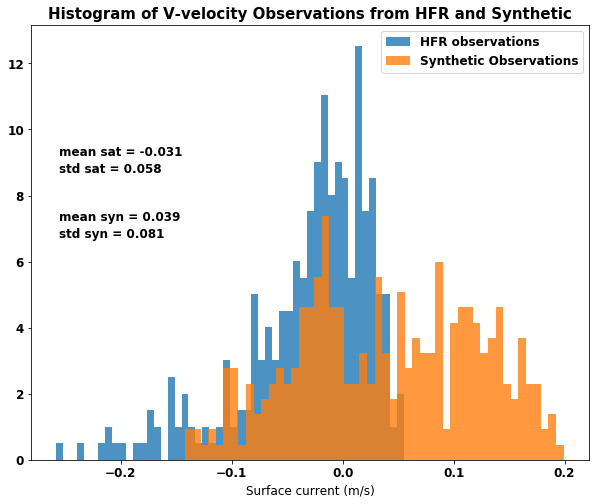

In [397]:
fig_vhfr_hist = plt.figure(figsize=(10,8))
ax = plt.subplot(111)

plt.hist(df_vhfr['val'], 50, density=True, alpha=0.8)
plt.hist(df_vhfr['v_interp'], 50, density=True, alpha=0.8)

plt.legend(['HFR observations', 'Synthetic Observations'])
plt.title('Histogram of V-velocity Observations from HFR and Synthetic', fontsize=15, fontweight='bold')
plt.xlabel('Surface current (m/s)')

plt.text(0.05, 0.7, 'mean sat = {0:0.3f}'.format(np.mean(df_vhfr['val'])), transform=ax.transAxes)
plt.text(0.05, 0.66, 'std sat = {0:0.3f}'.format(np.std(df_vhfr['val'])), transform=ax.transAxes)

plt.text(0.05, 0.55, 'mean syn = {0:0.3f}'.format(np.mean(df_vhfr['v_interp'])), transform=ax.transAxes)
plt.text(0.05, 0.51, 'std syn = {0:0.3f}'.format(np.std(df_vhfr['v_interp'])), transform=ax.transAxes)

plt.show()

In [398]:
fig_vhfr_hist.savefig('/home/jhernandez/Escritorio/histogram_vhfr_observations_OSSE.png', dpi=250)

## Create HF radar Observations from virtual antennas in Denia

#### Load Shapefile

In [5]:
import shapefile
from shapely.geometry import Point
from shapely.geometry import Polygon

In [6]:
# Path to shapefile
shape_path = '/home/jhernandez/Escritorio/mygeodata/'
shape_file = glob(shape_path + '/*shp')
# Load Shapefile
shape = shapefile.Reader(shape_file[0])

In [7]:
feature = shape.shapeRecords()[0]
first = feature.shape.__geo_interface__ 
coverage = Polygon(feature.shape.points)

### Plot coverage area Shapefile

In [8]:
lon = [a[0]  for a in feature.shape.points]
lat = [a[1]  for a in feature.shape.points]

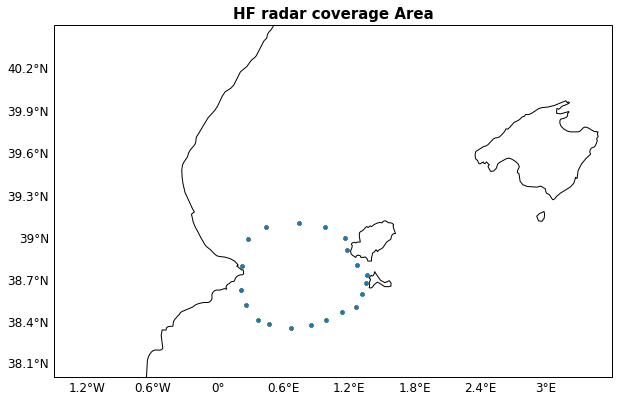

In [9]:
plt.figure(figsize=(10,10))

ax, gl = tools.make_map(continents=False, limits=[-1.5, 3.6, 38, 40.5])

for i in range(len(feature.shape.points)):
    plt.plot(lon, lat,'.', transform=gl.crs)
    
plt.title('HF radar coverage Area', fontweight='bold', fontsize=15)

plt.show()

#### Create mask

In [87]:
# Load WMOP file to extract Longitude and Latitude from
file_wmop = '{0}/roms_WMOP_FORECAST_{1}_his.nc'.format(nr_path, strdate)
ds_wmop = xr.open_dataset(file_wmop)


In [88]:
# Get index of bounding box limits
id1 = np.abs(ds_wmop.lon_u[1,:].values-0).argmin()
id2 = np.abs(ds_wmop.lon_u[1,:].values-1.4).argmin()
id3 = np.abs(ds_wmop.lat_u[:,1].values-38.3).argmin()
id4 = np.abs(ds_wmop.lat_u[:,1].values-39.2).argmin()

In [26]:
# Extract longitude and latitude for U and V for the area
lonu = ds_wmop.lon_u[id3:id4,id1:id2].values.reshape(-1)
latu = ds_wmop.lat_u[id3:id4,id1:id2].values.reshape(-1)
lonv = ds_wmop.lon_v[id3:id4,id1:id2].values.reshape(-1)
latv = ds_wmop.lat_v[id3:id4,id1:id2].values.reshape(-1)

In [89]:
mask_u = np.zeros(ds_wmop.lon_u.values.shape)
mask_v = np.zeros(ds_wmop.lon_v.values.shape)

# See  if point are contained within the polygon defined
mask_u1 = [coverage.contains(Point(lonu[i], latu[i])) for i in range(len(lonu))]
mask_v1 = [coverage.contains(Point(lonv[i], latv[i])) for i in range(len(lonv))] 
# Reshape to 2D
mask_u1 = np.array(mask_u1).reshape(id4-id3, id2-id1)
mask_v1 = np.array(mask_v1).reshape(id4-id3, id2-id1)

# Mask the whole domain
mask_u[id3:id4,id1:id2] = mask_u1
mask_v[id3:id4,id1:id2] = mask_v1

# Mask with NaNs
mask_u[mask_u==0] = np.nan
mask_v[mask_v==0] = np.nan

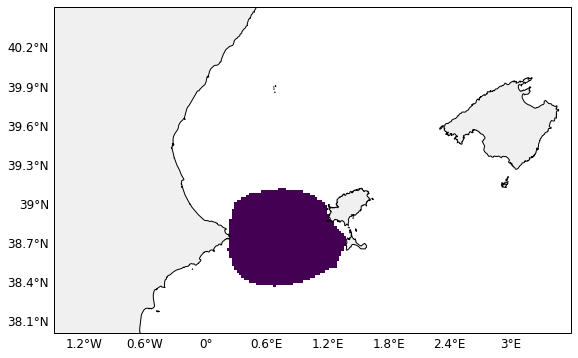

In [30]:
plt.figure(figsize=(12,6))

ax, gl = tools.make_map(continents=True, limits=[-1.5, 3.6, 38, 40.5])
plt.pcolormesh(ds_wmop.lon_u, ds_wmop.lat_u, mask_u, transform=gl.crs)

plt.show()

### Get Velocity Observations within the coverage area

In [352]:
# Get velocity fields
u = ds_wmop.u[:,-1,:,:].mean(axis=0).values
v = ds_wmop.v[:,-1,:,:].mean(axis=0).values
# Apply mask
u = u*mask_u
v = v*mask_v

# Reshape as array
u_1d = u[np.isnan(u)==0]
lon_u = ds_wmop.lon_u.values[np.isnan(u)==0]
lat_u = ds_wmop.lat_u.values[np.isnan(u)==0]

v_1d = v[np.isnan(v)==0]
lon_v = ds_wmop.lon_v.values[np.isnan(v)==0]
lat_v = ds_wmop.lat_v.values[np.isnan(v)==0]


In [96]:
import random

In [353]:
# Extract randomly a certain number of elements
idu = list(range(len(u_1d)))
idv = list(range(len(u_1d)))
random.shuffle(idu)
random.shuffle(idv)
# number of elements to extract
nb = len(u_1d)//15

# Extract randomly values for validation
u1 = u_1d[idu[1:nb]]
v1 = v_1d[idv[1:nb]]
lonu = lon_u[idu[1:nb]]
lonv = lon_v[idv[1:nb]]
latu = lat_u[idu[1:nb]]
latv = lat_v[idv[1:nb]]

u_1d[idu[1:nb]] = np.nan
v_1d[idv[1:nb]] = np.nan

# Get only valid observations
lon_u = lon_u[np.isnan(u_1d)==0]
lon_v = lon_v[np.isnan(v_1d)==0]
lat_u = lat_u[np.isnan(u_1d)==0]
lat_v = lat_v[np.isnan(v_1d)==0]
v_1d = v_1d[np.isnan(v_1d)==0]
u_1d = u_1d[np.isnan(u_1d)==0]

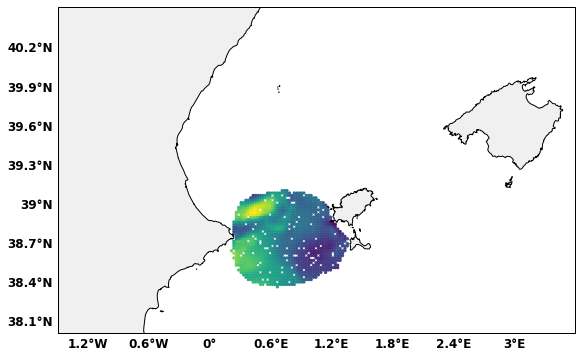

In [354]:
plt.figure(figsize=(12,6))

ax, gl = tools.make_map(continents=True, limits=[-1.5, 3.6, 38, 40.5])
plt.scatter(lon_u, lat_u, 5,  u_1d, transform=gl.crs)

plt.show()

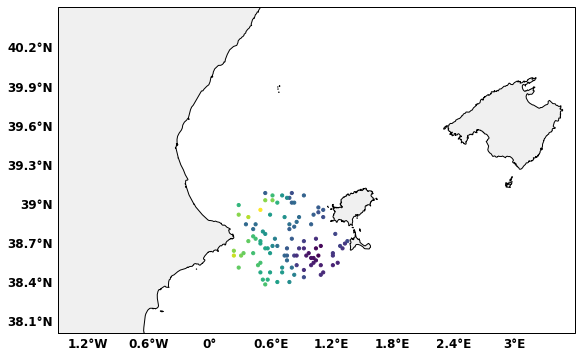

In [355]:
plt.figure(figsize=(12,6))

ax, gl = tools.make_map(continents=True, limits=[-1.5, 3.6, 38, 40.5])
plt.scatter(lonu, latu, 10,  u1, transform=gl.crs)

plt.show()

### Create DataFrame of subset for Validation

In [205]:
du_val = {'var': 'u', 'source': 'HF_Radar', 'year': date.year, 'month': date.month, 'day': date.day,'hour': date.hour,
        'minute': date.minute,'lon': lonu, 'lat':latu, 'depth': 0.0, 'val':u1, 'err': 0.01, 'rep': 1}
dv_val = {'var': 'v', 'source': 'HF_Radar', 'year': date.year, 'month': date.month, 'day': date.day,'hour': date.hour,
        'minute': date.minute,'lon': lonv, 'lat':latv, 'depth': 0.0, 'val':v1, 'err': 0.01, 'rep': 1}

dfu_val = pd.DataFrame(data=du_val)
dfv_val = pd.DataFrame(data=dv_val)

df_val = pd.concat([dfu_val, dfv_val])

### Create New DataFrame of Sinthetic Observations

In [207]:
du_new = {'var': 'u', 'source': 'HF_Radar', 'year': date.year, 'month': date.month, 'day': date.day,'hour': date.hour,
        'minute': date.minute,'lon': lon_u, 'lat':lat_u, 'depth': 0.0, 'val':u_1d, 'err': 0.01, 'rep': 1}
dv_new = {'var': 'v', 'source': 'HF_Radar', 'year': date.year, 'month': date.month, 'day': date.day,'hour': date.hour,
        'minute': date.minute,'lon': lon_v, 'lat':lat_v, 'depth': 0.0, 'val':v_1d, 'err': 0.01, 'rep': 1}

dfu_new = pd.DataFrame(data=du_new)
dfv_new = pd.DataFrame(data=dv_new)

df_hfr_new = pd.concat([dfu_new, dfv_new])

In [206]:
df_val

,var,source,year,month,day,hour,minute,lon,lat,depth,val,err,rep
0,u,HF_Radar,2014,9,20,9,0,0.759524,38.952844,0.0,0.228032,0.01,1
1,u,HF_Radar,2014,9,20,9,0,0.854762,38.878733,0.0,0.114122,0.01,1
2,u,HF_Radar,2014,9,20,9,0,0.973810,38.451091,0.0,0.060149,0.01,1
3,u,HF_Radar,2014,9,20,9,0,0.497619,38.952844,0.0,0.342966,0.01,1
4,u,HF_Radar,2014,9,20,9,0,0.854762,38.841648,0.0,0.110927,0.01,1
5,u,HF_Radar,2014,9,20,9,0,1.164286,38.562896,0.0,0.016892,0.01,1
6,u,HF_Radar,2014,9,20,9,0,0.973810,38.600126,0.0,0.015125,0.01,1
7,u,HF_Radar,2014,9,20,9,0,0.545238,38.971360,0.0,0.368187,0.01,1
8,u,HF_Radar,2014,9,20,9,0,0.545238,39.008377,0.0,0.204400,0.01,1
9,u,HF_Radar,2014,9,20,9,0,1.092857,38.469738,0.0,0.028241,0.01,1


In [222]:
save_path = '/DATA/jhernandez/WMOP_ASSIM/Observations/HFR_OSSE/'
output_file = '{0}assim_obs_HFR_all_channel_{1}.obs'.format(save_path, strdate)
output_file_val = '{0}assim_obs_HFR_validation_{1}.obs'.format(save_path, strdate)

In [223]:
output_file

'/DATA/jhernandez/WMOP_ASSIM/Observations/HFR_OSSE/assim_obs_HFR_all_channel_20140920.obs'

In [227]:
df_val.to_csv(output_file_val, header=None, sep=' ', index=False,  float_format='%.6f')
df_hfr_new.to_csv(output_file, header=None, sep=' ', index=False,  float_format='%.6f')

In [228]:
date + timedelta(days=3)

datetime.datetime(2014, 9, 23, 9, 0)